# EVOLUTIONARY CITY MODEL
## An Agent Based Model
*Put this notebook in the same folder where the virtualenv is created to avoid dependency conflicts.*

### Model Description 

* The model uses a payoff function of the form $$Ern + \frac{k}{r} - cn^2$$, 
    - $E$ is Shannon Entropy within a cell. We use the following discretized form with two types of agents ($L$ or $H$) depending on abilities. $$E = -\frac{t}{n}\log_e\left(\frac{t}{n}\right) - \frac{n-t}{n}\log_e\left(\frac{n-t}{n}\right)$$ 
    - $n$ is the number of agents in the cell
    - $t$ is the type count of agents in a cell depending on ability. Each agent is labelled type $H$(high skilled) for               $r\geqslant0.6$ or $L$ (low skilled) otherwise. 
    - $r$ is the ability of an agent, drawn from a uniform distribution (0,1). 
    - $k$ and $c$ are user settable coefficients and model parameters. 
    
    
* Agents use bounded rationality. Each agent is initialized with attribute **radius** which defines the maximum number of cells it considers while making a move. This is drawn from a beta distribution. 


* The model takes the total number of agents $N$, the positive coefficient $k$ and negative coefficient $c$ as inputs. The model also takes agent activation schedule as input to test two schedules. Pass **activation = 0** for Random Activation and **activation = 1** for Simultaneous Activation.


* The implementation defines the agents under class **habitant** and city model under class **city_model**. 

* **shannon_E** is a global function that returns the entropy of a cell. 


* There are 4 model level data collectors-
  - **city_sizes** -  returns an array corresponding to model grid containing the number of agents in each cell.   
  - **city_ranks** - returns a list of tuples. Each tuple contains the cell coordinates and its rank.
  - **model_entropy** - returns a list of lists. Each sublist contains the cell coordinates and its entropy.
  - **model_utility** - returns a utility of the entire model which is simply sum of individual agent utilities.  


* At each model step, the agents calculate the payoff before moving into one of their neighboring cells. If the payoff is higher than the agent's current cell, it makes a move otherwise stays put in his current cell.


In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import pandas as pd
import random
import numpy as np
import math
import time
import collections
import operator
from IPython.display import clear_output
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
from mesa.batchrunner import BatchRunner
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.ticker as ticker
import scipy.stats as st
from scipy.stats import norm

In [5]:
'''Function to calculate Entropies'''
def shanon_E(type_count, num_agents):
    t = type_count 
    n = num_agents
    if t == n or t == 0:
        return 0  # O entropy if all agents are of same type
    else:
        return -(t/n) * math.log(t/n) -((n - t)/n) * math.log((n - t)/n)


'''Model Reporters'''
def city_sizes(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count
    return agent_counts

def city_ranks(model):   
    ranklist = []
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        ranklist.append(((x,y),len(cell_content)))
        
    ranklist.sort(key=operator.itemgetter(1), reverse=True)
    return ranklist
        
def model_utility(model):
    agent_utility = [agent.utility(agent.pos) for agent in model.schedule.agents]
    return sum(agent_utility)

    
def model_entropy(model):
    entropy_list = []
    for cell in model.grid.coord_iter():
        type_count = 0
        cell_agents, x, y = cell
        num_agents = len(cell_agents)
        if num_agents != 0:
            for agent in cell_agents:
                if agent.type == 'L':
                    type_count += 1

            entropy_list.append([(x,y), shanon_E(type_count, num_agents)])
        else: entropy_list.append([(x,y),None])

    return entropy_list
    
'''Agent Class'''
class habitant(Agent):
    
    def __init__(self, unique_id, model, agent_ability):
        super().__init__(unique_id, model)
        self.r = agent_ability
        self.radius = math.ceil(np.random.beta(1,1) * (self.model.width/2))
        self.type = None
        if 0 <= 10*self.r < 6:
            self.type = 'L'
        elif 6 <= 10*self.r <=10:
            self.type = 'H' 
            
        self.steps = 0
        self.no_moves = 0

        
    def utility(self, coord):
                
        tot_agents = self.model.grid.get_cell_list_contents(coord)
        n = len(tot_agents)
        agent_types = [agent.type for agent in tot_agents]
        S = None
        if self.type == 'L':
            S = agent_types.count('L')
        else: 
            S = agent_types.count('H')
        if n!= 0:    
                     
            # check utility for current cell or neighbouring cell        
            if coord != self.pos:
                # +1 term if the agent considers neighbouring cell
                return (shanon_E(S+1,n+1) * self.r * (n + 1)) + (self.model.k / self.r) - (self.model.c * (n + 1)**2)  
            else:
                # utility stays the same if agent stays put in current cell
  
                return (shanon_E(S,n) * self.r * n) + (self.model.k / self.r) - (self.model.c * n**2)    
        
        else: return -math.inf      # return large negative value to restrict move to an empty cell   
    
    def move(self):
        
        neighbor_cell_pos = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False, radius=self.radius)
        cell_dict = {}     # define a cell dictionary = {keys = (coordinates): values = utiltity}
        max_pos = None
        
        for n in neighbor_cell_pos:     
            cell_dict[n] = self.utility(n)
                
        # no movement if all surrounding cells are empty        
        if sum(x == -math.inf for x in cell_dict.values()) == len(cell_dict):           
            self.no_moves += 1
        else: 
            # get the coordinates of maximum utility 
            max_pos = max(cell_dict, key = cell_dict.get)

            # move only when moving gives a utility benefit
            if self.utility(max_pos) > self.utility(self.pos):
                self.model.grid.move_agent(self, max_pos)
                
            else: self.no_moves += 1
                          
    def step(self):
        # for RandomActivation
        if self.model.act == 0:
            self.move()
        elif self.model.act == 1:
            self.steps += 1
    
    # for SimultaneousActivation
    def advance(self):    
        self.move()
        
'''Model Class'''
class city_model(Model):
    """Note the default model parameters"""
    def __init__(self, height = 20, width = 20, N = 1000, neg_coff = 0.1, pos_coff = 1, activation = 0):
        assert activation in [0,1], 'Activation should be "0 or 1". O for Random , 1 for Simultaneous'
        self.height = height
        self.width = width
        self.num_agents = N
        self.c = neg_coff
        self.k = pos_coff
        self.act = activation
        
        if self.act == 0:
            self.schedule = RandomActivation(self)
        elif self.act == 1:
            self.schedule = SimultaneousActivation(self) 
        
        self.grid = MultiGrid(width, height, True)
        self.running = True
        #Create agents with some ability
        for i in range(self.num_agents):
            agent_ability = np.random.uniform()
            agent = habitant(i, self, agent_ability)
            self.schedule.add(agent)
    
            # Add the agent to random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))
            
        self.datacollector = DataCollector(model_reporters = {"City_sizes": city_sizes, 
                                                              "Entropy": model_entropy,
                                                             "Ranks": city_ranks,
                                                             "Utility": model_utility}) 
      
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self) 
        self.schedule.step()

### Now, run the model and collect data

In [6]:
model = city_model() # default params used

for i in range(50): #run model for 50 steps
    model.step()
    
city_evolution = model.datacollector.get_model_vars_dataframe()

### Visualize city sizes at each step

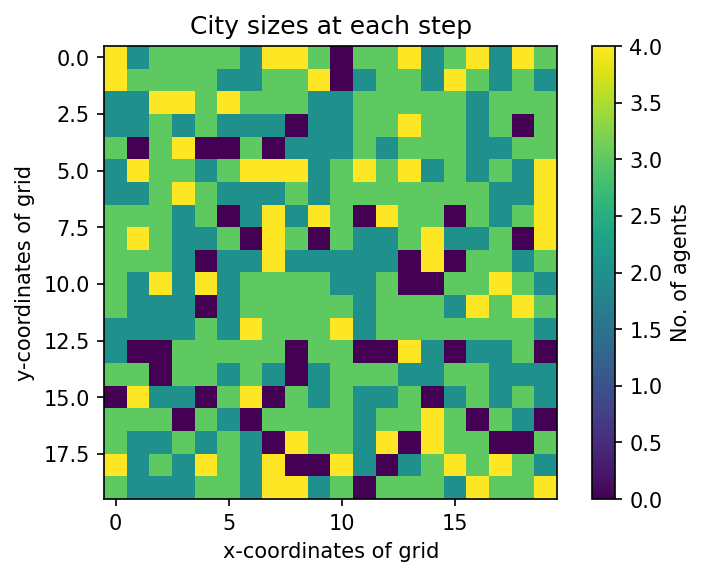

In [7]:
## Plot city sizes over time. Colorbar should have fixed values to make it more clear.
for i in range(50):
    fig = plt.figure(dpi=150)
    plt.imshow(city_evolution["City_sizes"][i])
    plt.title("City sizes at each step")
    plt.xlabel("x-coordinates of grid")
    plt.ylabel("y-coordinates of grid")
    plt.colorbar(label="No. of agents")
    plt.show()
    time.sleep(0.15)
    clear_output(wait=True)

### Plot overall model utitlites at each step

<AxesSubplot:title={'center':'Model Utilities at each step'}, xlabel='steps', ylabel='utility'>

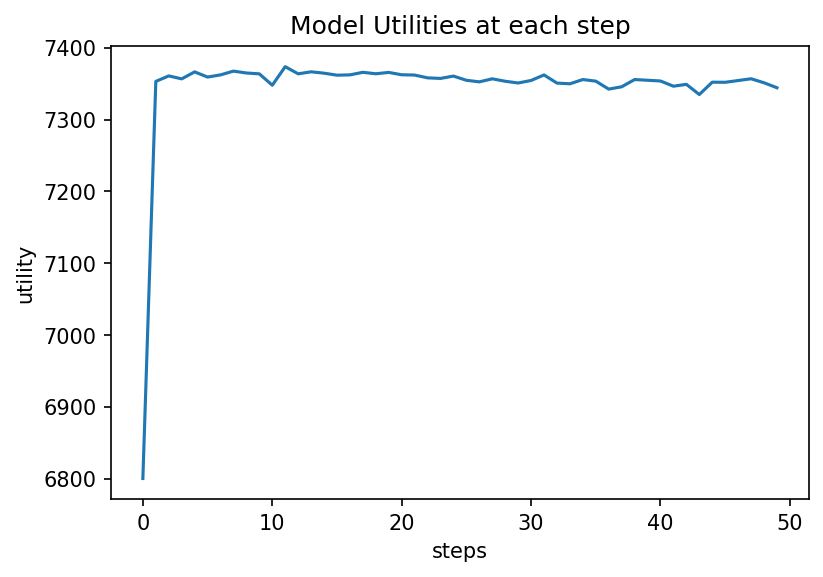

In [8]:
fig = plt.figure(dpi=150)
city_evolution["Utility"].plot(xlabel="steps", ylabel="utility",title="Model Utilities at each step")

### Visualize city rank - size distribution of cities(cells) at each step

In [10]:
city_evolution.head()

,City_sizes,Entropy,Ranks,Utility
0,"[[2.0, 6.0, 5.0, 8.0, 3.0, 3.0, 3.0, 2.0, 3.0,...","[[(0, 0), 0], [(0, 1), 0.6365141682948128], [(...","[((0, 3), 8), ((9, 17), 8), ((2, 5), 7), ((2, ...",6800.629615
1,"[[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 3.0, 2.0,...","[[(0, 0), 0.6365141682948128], [(0, 1), 0], [(...","[((0, 6), 4), ((2, 1), 4), ((2, 3), 4), ((2, 7...",7353.084777
2,"[[3.0, 2.0, 4.0, 2.0, 2.0, 3.0, 2.0, 3.0, 3.0,...","[[(0, 0), 0.6365141682948128], [(0, 1), 0], [(...","[((0, 2), 4), ((0, 19), 4), ((1, 0), 4), ((1, ...",7360.740523
3,"[[2.0, 2.0, 2.0, 4.0, 2.0, 3.0, 2.0, 2.0, 3.0,...","[[(0, 0), 0.6931471805599453], [(0, 1), 0], [(...","[((0, 3), 4), ((0, 14), 4), ((0, 16), 4), ((1,...",7356.604998
4,"[[2.0, 2.0, 2.0, 2.0, 4.0, 3.0, 2.0, 3.0, 3.0,...","[[(0, 0), 0.6931471805599453], [(0, 1), 0], [(...","[((0, 4), 4), ((0, 12), 4), ((1, 2), 4), ((2, ...",7366.342866


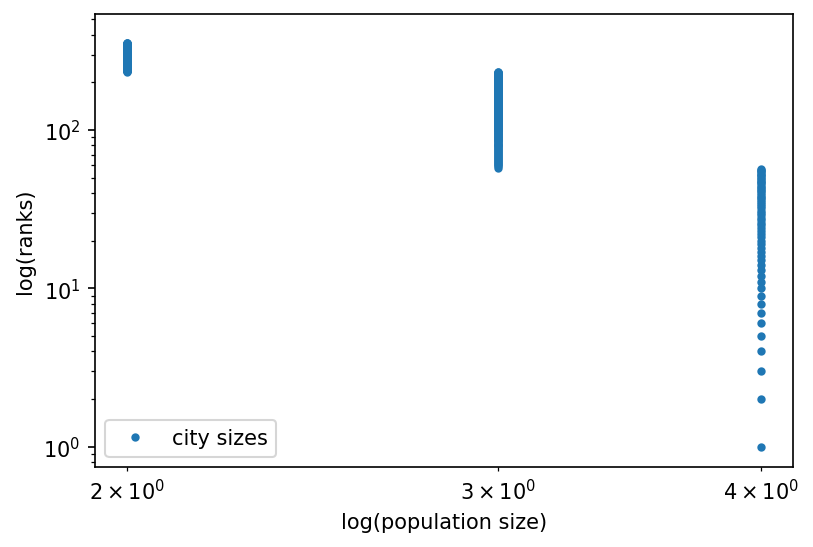

In [13]:
# consider adding regression line and overlay
for i in range(50):
    counts = city_evolution.iloc[i]["Ranks"]
    n = len(counts)
    ranks = range(1, n+1)                     # y-axis: log(the ranks)
    freqs = [freq for (word, freq) in counts] # x-axis: log(the poplution size)
    fig = plt.figure(dpi=150)
    plt.loglog(freqs, ranks, '.',label='city sizes') 
    plt.xlabel('log(population size)')
    plt.ylabel('log(ranks)')
    plt.legend(loc='lower left')
    plt.show()
    time.sleep(0.15)
    clear_output(wait=True)

### See entropy distribution of cities at the end of each Model run. 

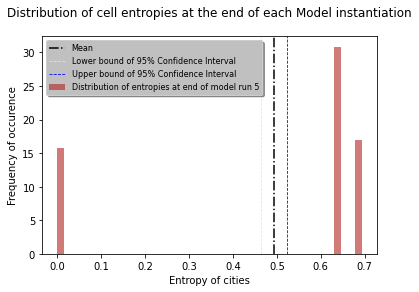

In [14]:
fig = plt.figure(dpi=200)
for i in range(5):
    model = city_model() # default params used
    for j in range(30): #run model for 30 steps
        model.step()
    city_evolution = model.datacollector.get_model_vars_dataframe()    
    eList = []
    for j in city_evolution.iloc[29]["Entropy"]:
        if j[1] != None:
            eList.append(j[1])   
    intv95 = st.norm.interval(alpha=0.95, loc=np.mean(eList), scale=st.sem(eList))
    mean, std = norm.fit(eList)
    # Plot the histogram.
    plt.hist(eList, bins= "auto", density=True,color='firebrick',alpha=0.6, 
             label="Distribution of entropies at end of model run {}".format(i+1))
    plt.axvline(x=np.mean(eList), color='k', linestyle='dashdot', label="Mean")
    plt.axvline(x=intv95[0],color='yellow',linestyle='--',linewidth=0.8,label='Lower bound of 95% Confidence Interval')
    plt.axvline(x=intv95[1],color='blue',linestyle='--',linewidth=0.8,label='Upper bound of 95% Confidence Interval')
    plt.xlabel('Entropy of cities')
    plt.ylabel('Frequency of occurence')
    plt.title("Distribution of cell entropies at the end of each Model instantiation",pad=20)
    plt.legend(loc='best', shadow=True, prop={'size': 8}, facecolor="silver")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

### Server

In [15]:
def city_draw(agent):
    """
    Portrayal Method for canvas
    """
    if agent.type == 'L':  # red for L
        portrayal = {"Shape": "rect","w": 0.2,"h":0.1, "Color": "red","Filled": "false","Layer":0 }
    else:                  # green for H
        portrayal = {"Shape": "circle","r": 0.5, "Color": "green","Filled": "true","Layer":1 }
            
    return portrayal

grid = CanvasGrid(city_draw, 20, 20, 500, 500)
chart = ChartModule([{"Label": "Utility",
                      "Color": "Black"}],
                    data_collector_name='datacollector')
model_params = {
    "height": 20,
    "width": 20,
    "N": UserSettableParameter("slider", "Number of Agents", 1000, 500, 2500, 500),
    "neg_coff": UserSettableParameter("slider", "Negative coefficient(c)", 0.1, 0.05, 0.25, 0.05),
    "pos_coff": UserSettableParameter("slider", "Positive Coefficeint(k)", 1, 0.5, 2, 0.25),
    "activation": UserSettableParameter("slider", "0 for Random, 1 for Simulatneous", 0, 0, 1, 1)}

server = ModularServer(city_model, [grid, chart], "City Model", model_params)
server.launch()

Interface starting at http://127.0.0.1:8521


AssertionError: 

Socket opened!
{"type":"reset"}
{"type":"submit_params","param":"N","value":1500}
{"type":"submit_params","param":"N","value":1000}
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","